# Time series interpolation and forecasting

This tutorial introduces the basic features and settings of `gallifrey` and how it can be used for interpolation and forecasting of a time series. In particular, we will look at a few days of TESS observations for the target _TIC 10863087_, a variable M dwarf star that was also presented as a case study in the python <a href="https://gallery.exoplanet.codes/tutorials/stellar-variability/">exoplanet</a> package.


## Notebook setup

First things first, we need to set up the notebook properly.

> We will run this notebook on a CPU, and since SMC is an inherently parallel algorithm, we want to use all available cores. By default, JAX recognises a CPU only as a single device. To register the available cores as independent devices, we have to set the XLA_FLAGS **before importing JAX and any JAX-using libraries**.

In [4]:
# register all available CPU cores for XLA
import multiprocessing
import os

os.environ["XLA_FLAGS"] = (
    f"--xla_force_host_platform_device_count={multiprocessing.cpu_count()}"
)

In [5]:
# now do imports
import pathlib

import astroquery.mast as mast
import jax.numpy as jnp
import jax.random as jr
import lightkurve as lk
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from gallifrey import GPConfig, GPModel, LinearSchedule
from gallifrey.data import Dataset

gallifrey: Setting flag `JAX_ENABLE_X64` to `True`
gallifrey: Setting flag `OMP_NUM_THREADS` to `1`


By default, gallifrey enables the 64-bit mode in JAX, this makes for more stable matrix inversion in the GP algorithms. We also set `OMP_NUM_THREADS` to 1.

In [6]:
# notebook settings

# making the plots pretty
sns.set_theme(
    context="poster",
    style="ticks",
    palette="rocket",
    font_scale=1,
    rc={
        "figure.figsize": (16, 7),
        "axes.grid": False,
        "font.family": "serif",
        "text.usetex": True,
        "lines.linewidth": 5,
        # "axes.grid": True,
    },
)

# and setting saving defaults
save_figures = True
load_models = True  # load pre-trained models,

# set saving paths
path = pathlib.Path.cwd().parent
figure_directory = path / "figures/stellar_variability/"
if not figure_directory.exists():
    figure_directory.mkdir(parents=True)

# set a random key for for this notebook
rng_key = jr.PRNGKey(12)

## Data preparation and exploration

Let's first gather some information about the target. As mentioned before, we are looking at target _10863087_ from the TESS Input Catalogue (_TIC_). We can use `astroquery` to obtain some basic information on the target first.

In [7]:
target = "TIC 10863087"

# get basic stellar properties
stellar_parameters = (
    mast.Catalogs.query_object(target, radius=0.01, catalog="TIC")
    .to_pandas()
    .filter(
        [
            "objType",
            "ra",
            "dec",
            "mass",
            "e_mass",
            "radius",
            "e_radius",
            "Teff",
            "e_Teff",
            "logg",
            "e_logg",
            "Vmag",
            "e_Vmag",
        ]
    )
)
stellar_parameters

,objType,ra,dec,mass,e_mass,Teff,e_Teff,logg,e_logg,Vmag,e_Vmag
0,STAR,25.938103,-6.0445,0.397525,0.02021,3296.0,157.0,4.82174,0.003616,12.949,0.099


So we can see that the target is a star with a mass around 0.4 solar masses and a V-band magnitude of 12.95. Now to obtains a section of it's observed light curve, we make use of the `lightkurve` package. We gather ~7 days of observation data, thin the lightcurve to use only every sixth points, and further remove outliers and NaNs. That leaves us with a time series of 814 data points.

In [8]:
# get lightcurve
lcf = (
    lk.search_lightcurve("TIC 10863087", mission="TESS", author="SPOC", limit=1)
    .download(quality_bitmask="hard")
    .remove_nans()
)
# we thin the lightcurve to speed up the GP fitting, and remove outliers
lc = lcf[100:5000:6].remove_outliers(sigma=3)

# convert to pandas dataframe
df = (
    lc.to_pandas()
    .reset_index()
    .filter(["time", "flux", "flux_err"])
    .rename(
        columns={
            "time": "Time [Days]",
            "flux": r"Flux [$\frac{\mathrm{e}^{-}}{\mathrm{s}}$]",
            "flux_err": r"Flux Error [$\frac{\mathrm{e}^{-}}{\mathrm{s}}$]]",
        }
    )
)
print("\nNumber of data points:", len(df))


Number of data points: 814


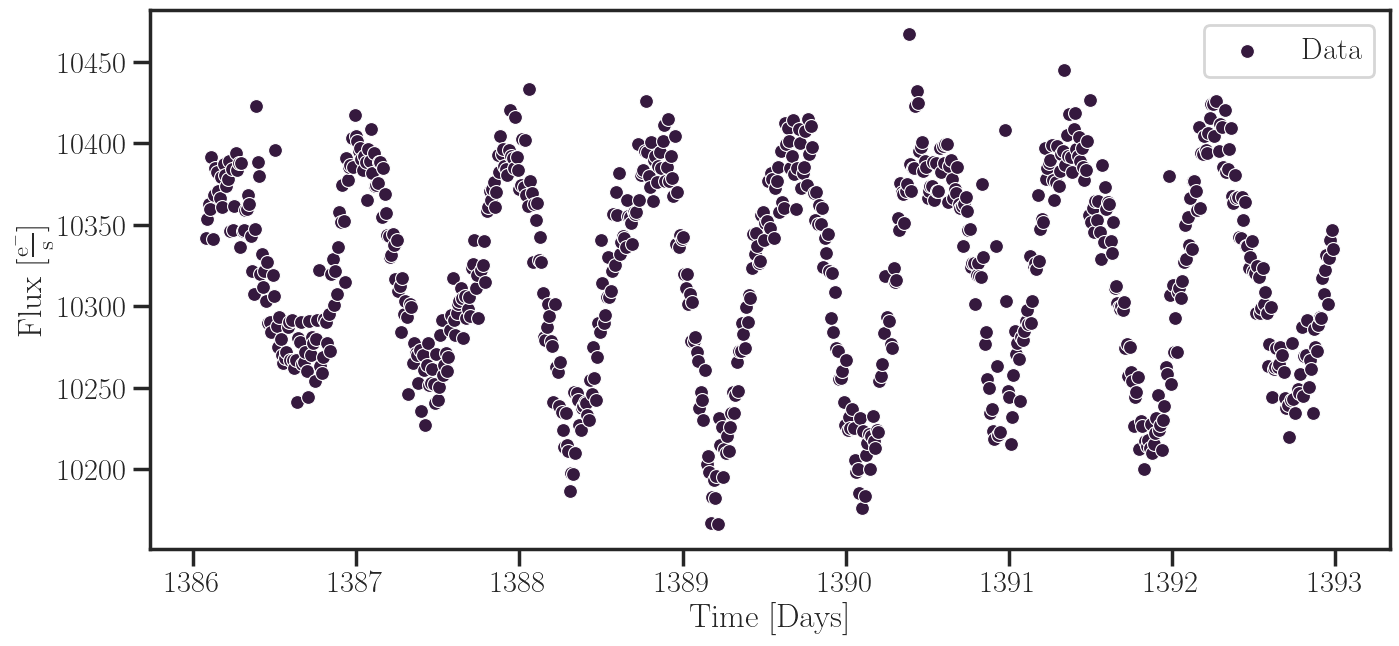

In [9]:
data_plot = sns.scatterplot(
    df,
    x="Time [Days]",
    y=r"Flux [$\frac{\mathrm{e}^{-}}{\mathrm{s}}$]",
    label="Data",
    s=100,
)
if save_figures:
    plt.savefig(figure_directory / "data_plot.pdf", bbox_inches="tight")

## Interpolation

The first thing we can look at is how well `gallifrey` performs at interpolating a missing piece this time series. We can see a clearly see an oscillatory pattern in this time series, so we better hope `gallifrey` picks up on that. Lets first select a subset of the data to remove, say between day 1388 and 1390. We use the remainder of the data for training and to condition our Gaussian Process on.

In [10]:
# first, transform the data to jax arrays
x = jnp.array(df["Time [Days]"])
y = jnp.array(df[r"Flux [$\frac{\mathrm{e}^{-}}{\mathrm{s}}$]"])

# now remove a window of data points
mask_interpolation = (x > 1388) & (x < 1390)
xtrain = x[~mask_interpolation]
ytrain = y[~mask_interpolation]
xall = x

The next thing we need to do is set up the config for our Gaussian Process model. `gallifrey` is set up in such a way that it should work out of the box for many different forms of data. But for this example, let's make things more explicit. The `GPConfig` class hosts most of the settings that can be controlled my the user. The major settings are the following:


>**max_depth**: The maximum depth of the binary tree that makes up the GP kernel. Higher values allow for more complex models, but at the expense of higher computation time. The default value is 3, which should suffice for smooth and continous time series. 

>**atoms** : This is a list of the available base GP kernels (such as Linear, Periodic, etc..). Each kernel in this list can act as a leaf in the binary kernel tree that makes up the overall kernel structure. Most commonly used kernels are implemented in the `gallifrey.kernels.atoms` module. We use the default list of kernels, which includes a
 ><ul>
 > <li>Linear Kernel</li>
 > <li>Periodic Kernel</li>
 > <li>RBF (Radial Basis Function/Squared Exponential) Kernel</li>
></ul> 

>**operators** : Addition or Multiplication of kernel atoms also yield valid kernels. This is the main way to combine kernels to construct the kernel tree. We implement these operations as `Operatior`s `gallifrey.kernels.atoms` module. By default, the `SumOperator` and `ProductOperatur` included, so that both sums and products of kernels are considered

>**node_probabilities** : Finally, when running the `fit_mcmc` or `fit_smc` methods in a gallifrey model, kernel trees are constructed by randomly sampling from the available atoms and operators. The node_probabilities array assigns selection probabilities to each of these options.  This array should have a length equal to the sum of the number of kernels and operators. The first part of the array should contain the probabilities for sampling the kernels (in the order of them being listed in the `atoms` attribute), and the second part should contain the probabilities for sampling the operators (in the order of them being listed in the `operators` attribute).By default, the probabilities are set to be equal for all kernels, and
half that probability for the operators (to encourage kernels with fewer terms).

If want to use the default options, you can just invoke the config like this

In [11]:
config = GPConfig()

But if you want to make changes, you can explicitly pass arguments, e.g.

In [12]:
from gallifrey.kernels.atoms import (
    LinearAtom,
    PeriodicAtom,
    ProductOperator,
    RBFAtom,
    SumOperator,
)

config = GPConfig(
    max_depth=3,
    atoms=[LinearAtom(), PeriodicAtom(), RBFAtom()],
    operators=[SumOperator(), ProductOperator()],
    node_probabilities=jnp.array([1.0, 1.0, 1.0, 0.5, 0.5]),
)

Now we create a GPModel object and fit it to the data, to do so, we pass a the training data, config and random key to the `GPModel` constructor. We also decide on the number of particles in the ensemble

>The parallelisation over different particles is currently implemented using JAX's `pmap` function, which limits us to a number of particles that is less or equal to the number of available cores.

In [13]:
# create GP model instance
key, model_key = jr.split(rng_key)
gpmodel = GPModel(
    model_key,
    x=xtrain,
    y=ytrain,
    num_particles=6,
    config=config,
)

The `model_key` is used to create the initial ensemble of particles, which are drawn from a prior that constructed using the arguments in the `GPconfig`. We can visualise the first 5 members of the initial ensemble as follows

In [14]:
gpmodel.display(num_particles=3)

Particle 1 | Variance: 1.0740917544050912 
*
└── Linear: [0.73385188]
└── Periodic: [0.38990454 1.08583796 0.94300419]

Particle 2 | Variance: 1.6983593526390177 
Linear: [0.47201347]

Particle 3 | Variance: 5.163133476632695 
*
└── Linear: [1.8165231]
└── RBF: [1.75840451 2.69949143]



We are ready to fit the model to the data. We will use the Sequential Monte Carlo (SMC) sampler to perform the sampling. The SMC sampler performs the sampling via data annealing, meaning that in each round more data is added. To create an annealing schedule, we use `gallifrey.schedule.LinearSchedule`. We also need to decide how many MCMC steps are performed over the kernel structures, and how many HMC (Hamiltonian Monte Carlo) steps are performed over the kernel parameters.

(Note: if you run the example given here, we use 6 particles with 10 SMC rounds. If you instead load the model checkpoint, it will be 64 particles with 20 SMC rounds.)

In [15]:
# run the model

if load_models is False:
    key, smc_key = jr.split(key)
    final_smc_state, history = gpmodel.fit_smc(
        smc_key,
        annealing_schedule=LinearSchedule().generate(len(xtrain), 10),
        n_mcmc=75,
        n_hmc=10,
        verbosity=1,
    )
else:
    final_smc_state = gpmodel.load_state(
        str(
            path / "model_checkpoints/stellar_variability_interpolation/final_state.pkl"
        )
    )
    history = gpmodel.load_state(
        str(path / "model_checkpoints/stellar_variability_interpolation/history.pkl")
    )

# update the model with the new state
gpmodel = gpmodel.update_state(final_smc_state)

In [16]:
gpmodel.display(num_particles=2)

Particle 1 | Weight: 0.03 | Variance: 0.009701915947732747 
*
└── *
    └── +
        └── Periodic: [0.66834122 5.34428713 1.71528721]
        └── RBF: [0.96532584 0.84700439]
    └── *
        └── RBF: [0.98132759 0.17626192]
        └── Periodic: [2.69859038 0.30746604 4.17483938]
└── +
    └── *
        └── Linear: [1.22759597]
        └── RBF: [0.82610079 1.06687129]
    └── *
        └── RBF: [0.55356261 0.54715645]
        └── Periodic: [1.25118302 1.7167952  0.13142572]

Particle 2 | Weight: 0.01 | Variance: 0.009775859653600047 
*
└── RBF: [2.3458651  0.31270641]
└── +
    └── Linear: [0.36739003]
    └── *
        └── Periodic: [0.40767254 0.40475807 1.79032924]
        └── Periodic: [0.72147762 0.41304572 0.13346414]



We can see that the model has learned a more intricate kernel structure to describe the data, one for each particles. Let's now check the forecasting capabilities of the learned kernels. We use the training data to condition the GP model and create predictions for the remainder of the time series.  Since each particle in our ensemble is modeled as a Gaussian Process (GP), their predictive distributions take the form of Multivariate Gaussians. Consequently, the predictive distribution for the entire ensemble can be determined by simply combining the predictive distributions of individual particles. The result in a Gaussian Mixture Model (GMM), where the weights of each Gaussian component are determined by the importance weights derived from the Sequential Monte Carlo (SMC) sampling. The `gallifrey` model contains a simple function obtain this mixture distribution as a `tensorflow_probability` distribution object.

>A `gallifrey` model instance internally transforms the input data using a linear transformation. Both x and y get normalised, so that x is constrained to lie between 0 and 1, and y between -0.5 and 0.5. This results in more stable learning across different datasets, but we need to manually transform the data we want to predict on as well. The `GPModel` instance provides convenient methods to do these transformations.

In [14]:
# use all the data for prediction, and transform the data to the normalised space
xall_norm = gpmodel.x_transform(xall)

# now we can get the predictive distribution
predictive_gmm = gpmodel.get_mixture_distribution(xall_norm)

Now, we can calculate the model prediction. The mean and standard deviation are easily be easily obtained in closed form, while percentiles can be calculated from a sample of the GP.

In [15]:
# calculate the mean and std of the predictive distribution
predictive_mean = predictive_gmm.mean()
predictive_stddev = predictive_gmm.stddev()

# calculate the median and 16th and 84th percentiles from a sample
# key, sample_key = jr.split(key)
# samples = predictive_gmm.sample(seed=sample_key, sample_shape=(int(1e4),))
# sample_percentiles = jnp.percentile(samples, q=jnp.array([16, 50, 84]), axis=0)

Now let's plot the data and prediction. Since the absolute value of the flux is not too important here, we can stick with the normalised fluxes that the `GPModel` provides. For the training data, the GP model has an attribute `y_transformed`, which contains the already transformed training data. For the test data, we need to manually transform the data using the `y_transform` method.

In [16]:
# prepare the test data the test data
x_predict = x[mask_interpolation]
y_predict = y[mask_interpolation]
y_predict_norm = gpmodel.y_transform(
    y_predict  # transform the data to the normalised space!
)

In [17]:
# create a convienience function to plot the intervals in different colors
def plot_intervals(ax, x, mean, fill_lower, fill_upper, masks, colors):
    last_index = 0
    for i in range(len(masks)):
        mask = masks[i]
        color = colors[i]
        # get indices of mask, add last index from previous mask
        # for smooth plotting
        indices = jnp.insert(jnp.where(mask)[0], 0, last_index)
        xm = x[indices]

        # plot means
        sns.lineplot(x=xm, y=mean[indices], color=color, ax=ax)

        # plot stddevs
        ax.fill_between(
            xm,
            fill_lower[indices],
            fill_upper[indices],
            color=color,
            alpha=0.3,
        )
        sns.lineplot(
            x=xm, y=fill_lower[indices], color=color, ax=ax, linestyle="--", linewidth=2
        )
        sns.lineplot(
            x=xm, y=fill_upper[indices], color=color, ax=ax, linestyle="--", linewidth=2
        )

        last_index = indices[-1]  # update last index
    return ax

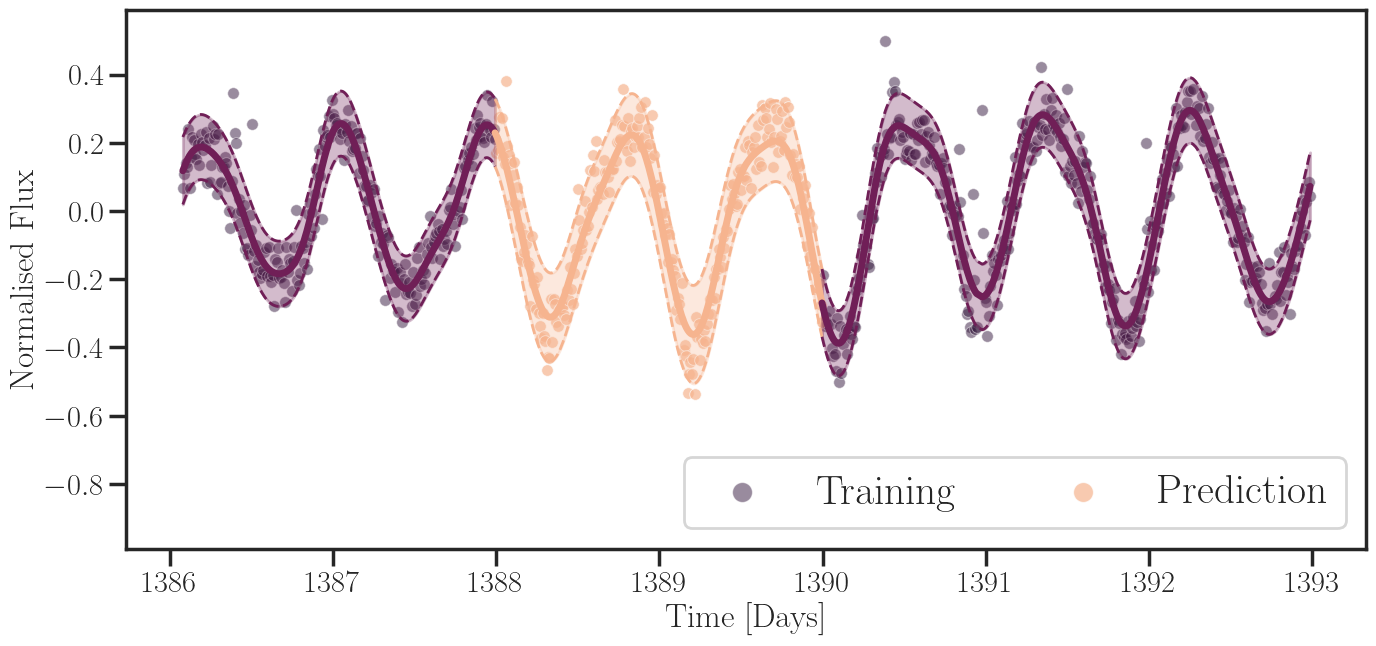

In [ ]:
# plot the training data and the prediction
prediction_plot = sns.scatterplot(
    x=gpmodel.x,
    y=gpmodel.y_transformed,
    label="Training",
    color="C0",
    alpha=0.5,
    s=70,
)

sns.scatterplot(
    x=x_predict,
    y=y_predict_norm,
    label="Prediction",
    color="C5",
    ax=prediction_plot,
    s=70,
    alpha=0.7,
)

# plot mean and standard deviation
masks = [
    ~mask_interpolation & (xall < 1390),
    mask_interpolation,
    ~mask_interpolation & (xall > 1390),
]
colors = ["C1", "C5", "C1"]
prediction_plot = plot_intervals(
    prediction_plot,
    xall,
    predictive_mean,
    predictive_mean - predictive_stddev,
    predictive_mean + predictive_stddev,
    masks,
    colors,
)


prediction_plot.set_xlabel("Time [Days]")
prediction_plot.set_ylabel(r"Normalised Flux")
prediction_plot.set_ylim(-0.99, 0.59)
prediction_plot.legend(
    ncols=2,
    loc="lower right",
    fontsize=30,
    markerscale=1.7,
)

if save_figures:
    plt.savefig(figure_directory / "interpolation_plot.pdf", bbox_inches="tight")

That looks pretty good! The model correctly picked up on the (quite obvious) oscillations, and predicts the masked area quite well.

Apart from the mixture distribution of the entire ensemble, we can also look at the predictions of the individual partiles, which are simple Gaussian distributions. To get a list of of the predictive distributions for each particle we can use the `get_predictive_distributions` method of the `GPModel`.

In [24]:
# get list of individual predictive distributions for each particle
particle_distributions = gpmodel.get_predictive_distributions(xall_norm)

Let's plot a random subsample of particles.

In [25]:
# get distributions of a random subset of particles
n_particles = 6
key, sample_key = jr.split(key)  # split the key
sample_indices = jr.choice(  # get indices using the key
    sample_key,
    jnp.arange(len(particle_distributions)),
    (n_particles,),
    replace=False,
)
sample_distributions = [particle_distributions[i] for i in sample_indices]

# calculate the mean and std of the predictive distribution
means = [dist.mean() for dist in sample_distributions]
stddevs = [dist.stddev() for dist in sample_distributions]
lower = [mean - stddev for mean, stddev in zip(means, stddevs)]
upper = [mean + stddev for mean, stddev in zip(means, stddevs)]

# make a dataframe for easy plotting
df = pd.DataFrame(
    {
        "Time [Days]": jnp.tile(xall, n_particles),
        "Normalised Flux": jnp.concatenate(means),
        "Lower": jnp.concatenate(lower),
        "Upper": jnp.concatenate(upper),
        "Particle": jnp.repeat(jnp.arange(n_particles), len(xall)),
    }
)

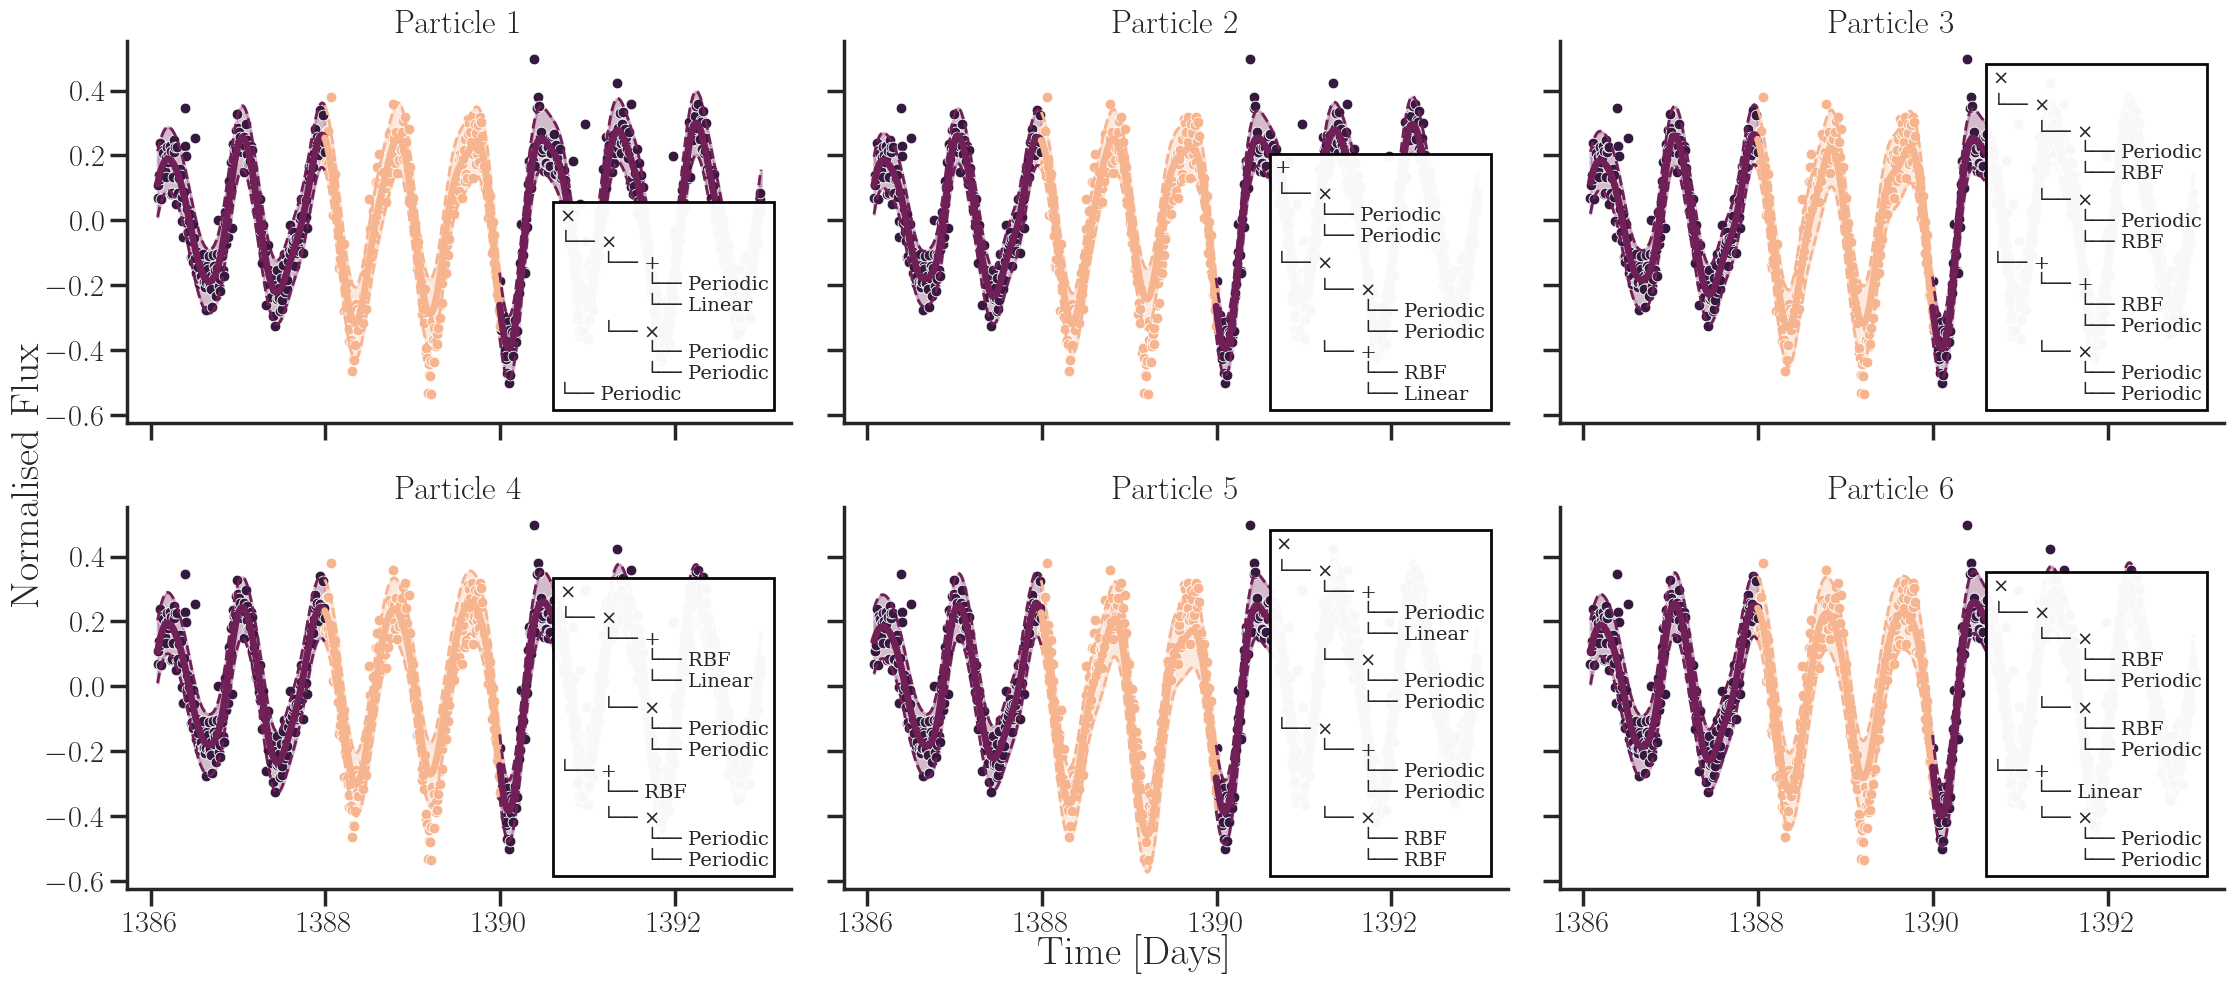

In [27]:
# create plot grid
particle_plot = sns.FacetGrid(
    df,
    col="Particle",
    col_wrap=3,
    sharey=True,
    sharex=True,
    height=5,
    aspect=1.5,
)

# plot the predictive mean and standard deviation
for i, ax in enumerate(particle_plot.axes):
    plot_intervals(
        ax,
        xall,
        means[i],
        lower[i],
        upper[i],
        masks,
        colors,
    )

# plot training and test data
particle_plot.map(
    sns.scatterplot,
    x=gpmodel.x,
    y=gpmodel.y_transformed,
    color="C0",
    label="Training",
    s=60,
)
particle_plot.map(
    sns.scatterplot,
    x=x_predict,
    y=y_predict_norm,
    color="C5",
    label="Prediction",
    s=60,
)

# set titles
for i, ax in enumerate(particle_plot.axes):
    ax.set_title(f"Particle {i+1}")

# add kernel descriptions
kernel_descriptions = [
    gpmodel.get_particles()[i]
    .kernel._tree_viz(include_parameters=False)
    .replace("*", r"$\times$")
    .replace("   ", "      ")[:-1]
    for i in sample_indices
]
for i, ax in enumerate(particle_plot.axes):
    ax.text(
        0.65,
        0.05,
        kernel_descriptions[i],
        horizontalalignment="left",
        verticalalignment="bottom",
        transform=ax.transAxes,
        fontsize=14,
        usetex=False,
        bbox=dict(facecolor="white", alpha=0.97, edgecolor="black"),
    )

particle_plot.figure.supxlabel("Time [Days]", y=0)
particle_plot.figure.supylabel("Normalised Flux", x=0)
if save_figures:
    particle_plot.savefig(
        figure_directory / "particle_interpolation_plot.pdf", bbox_inches="tight"
    )

All of the particles pick up on the periodic signal in the data, and do a reasonable job at interpolating. But you can see that they have a tendency to be overconfident in their estimate of the amplitude (this can be seen escpecially clearly for Particle 4 and 6). Keeping an ensemble of particles instead leads to a more robust prediction.

## Extrapolation/Forecasting

Another task we can look at is forecasting the time series. For this exercise, we start again with the same initial GP model (we even use the same initial random key!) and this time mask out everything in the time series beyond day 1390.

In [18]:
# create training data
mask_extrapolation = x < 1390
xtrain = x[mask_extrapolation]
ytrain = y[mask_extrapolation]

# initialise the model
gpmodel = GPModel(
    model_key,
    x=xtrain,
    y=ytrain,
    num_particles=6,
    config=config,
)

In [19]:
# run the model

if load_models is False:
    key, smc_key = jr.split(key)
    final_smc_state, history = gpmodel.fit_smc(
        smc_key,
        annealing_schedule=LinearSchedule().generate(len(xtrain), 20),
        n_mcmc=75,
        n_hmc=10,
        verbosity=1,
    )
else:
    final_smc_state = gpmodel.load_state(
        str(
            path / "model_checkpoints/stellar_variability_extrapolation/final_state.pkl"
        )
    )
    history = gpmodel.load_state(
        str(path / "model_checkpoints/stellar_variability_extrapolation/history.pkl")
    )


# update the model with the new state
gpmodel = gpmodel.update_state(final_smc_state)

We calculate and plot the predictive distribution again:

In [20]:
# now we can get the predictive distribution
xall_norm = gpmodel.x_transform(xall)

predictive_gmm = gpmodel.get_mixture_distribution(xall_norm)
predictive_mean = predictive_gmm.mean()
predictive_stddev = predictive_gmm.stddev()

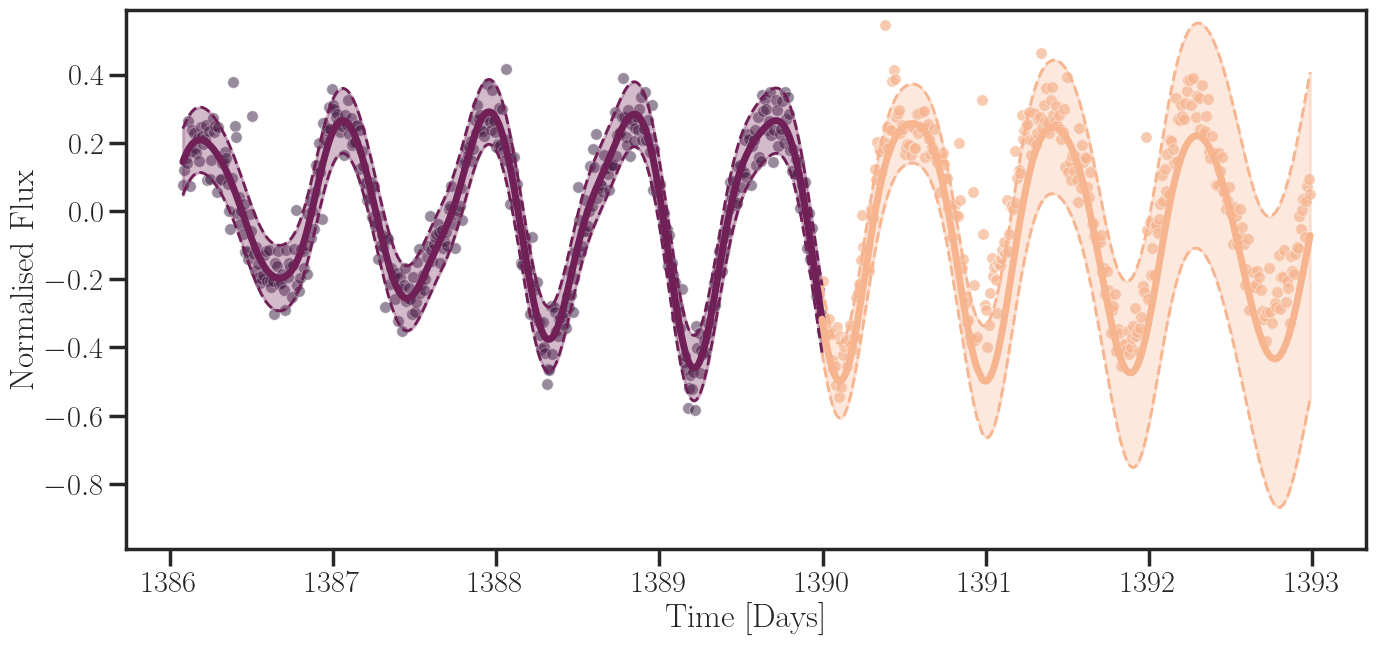

In [21]:
# plot the training data
prediction_plot = sns.scatterplot(
    x=gpmodel.x,
    y=gpmodel.y_transformed,
    color="C0",
    alpha=0.5,
    s=70,
)

sns.scatterplot(
    x=x[~mask_extrapolation],
    y=gpmodel.y_transform(y[~mask_extrapolation]),
    color="C5",
    ax=prediction_plot,
    s=70,
    alpha=0.7,
)

# plot mean and standard deviation
masks = [mask_extrapolation, ~mask_extrapolation]
colors = ["C1", "C5"]
prediction_plot = plot_intervals(
    prediction_plot,
    xall,
    predictive_mean,
    predictive_mean - predictive_stddev,
    predictive_mean + predictive_stddev,
    masks,
    colors,
)


prediction_plot.set_xlabel("Time [Days]")
prediction_plot.set_ylabel(r"Normalised Flux")
prediction_plot.set_ylim(-0.99, 0.59)
if save_figures:
    plt.savefig(figure_directory / "extrapolation_plot.pdf", bbox_inches="tight")

The model again does a pretty good job! The mean prediction and actual data are pretty close up to one day after the observations. As the forecast horizon increases, the predictions become more uncertain, and the mean prediction deviates more strongly from the true data. Yet they stay within one standard deviation of the model.

We also look at a different feature that comes with the SMC sampler, namely how the prediction changes over time as we add more data. For this, the `fit_smc` method returns not only the final state of the model, but also checkpoints at every completed SMC round. Both the final state, and the history is stored as a `GPState` instance. The history contains the batched states after every SMC round. We can unbatch these states using the `unbatch_states` function

In [22]:
from gallifrey.model import unbatch_states

history_states = unbatch_states(history)

Now, we can calculate the predictive distribution after every round of SMC. We have to make sure to only condition the GP on data that was seen up this step in the data annealing schedule. To do this, we manually pass a `Dataset` object to the `get_mixture_distribution` attribute, making again sure we pass the normalised data. For plotting purposes, let's only take a look at a subset of states:

In [23]:
means = []
lower = []
upper = []
datapoints = []
masks = []

for state in history_states[2::2]:
    gpmodel_hist = gpmodel.update_state(state)

    included_datapoints = state.num_data_points
    data_norm = Dataset(
        x=gpmodel.x_transform(xtrain[:included_datapoints]),
        y=gpmodel.y_transform(ytrain[:included_datapoints]),
    )

    predictive_gmm = gpmodel_hist.get_mixture_distribution(xall_norm, data=data_norm)
    means.append(predictive_gmm.mean())
    stddevs = predictive_gmm.stddev()
    lower.append(predictive_gmm.mean() - stddevs)
    upper.append(predictive_gmm.mean() + stddevs)
    datapoints.append(jnp.repeat(included_datapoints, len(xall)))
    masks.append([xall < xall[included_datapoints], xall >= xall[included_datapoints]])

# make a dataframe for easy plotting
df = pd.DataFrame(
    {
        "Time [Days]": jnp.tile(xall, len(means)),
        "Normalised Flux": jnp.concatenate(means),
        "Lower": jnp.concatenate(lower),
        "Upper": jnp.concatenate(upper),
        "Datapoints": jnp.concatenate(datapoints),
    }
)

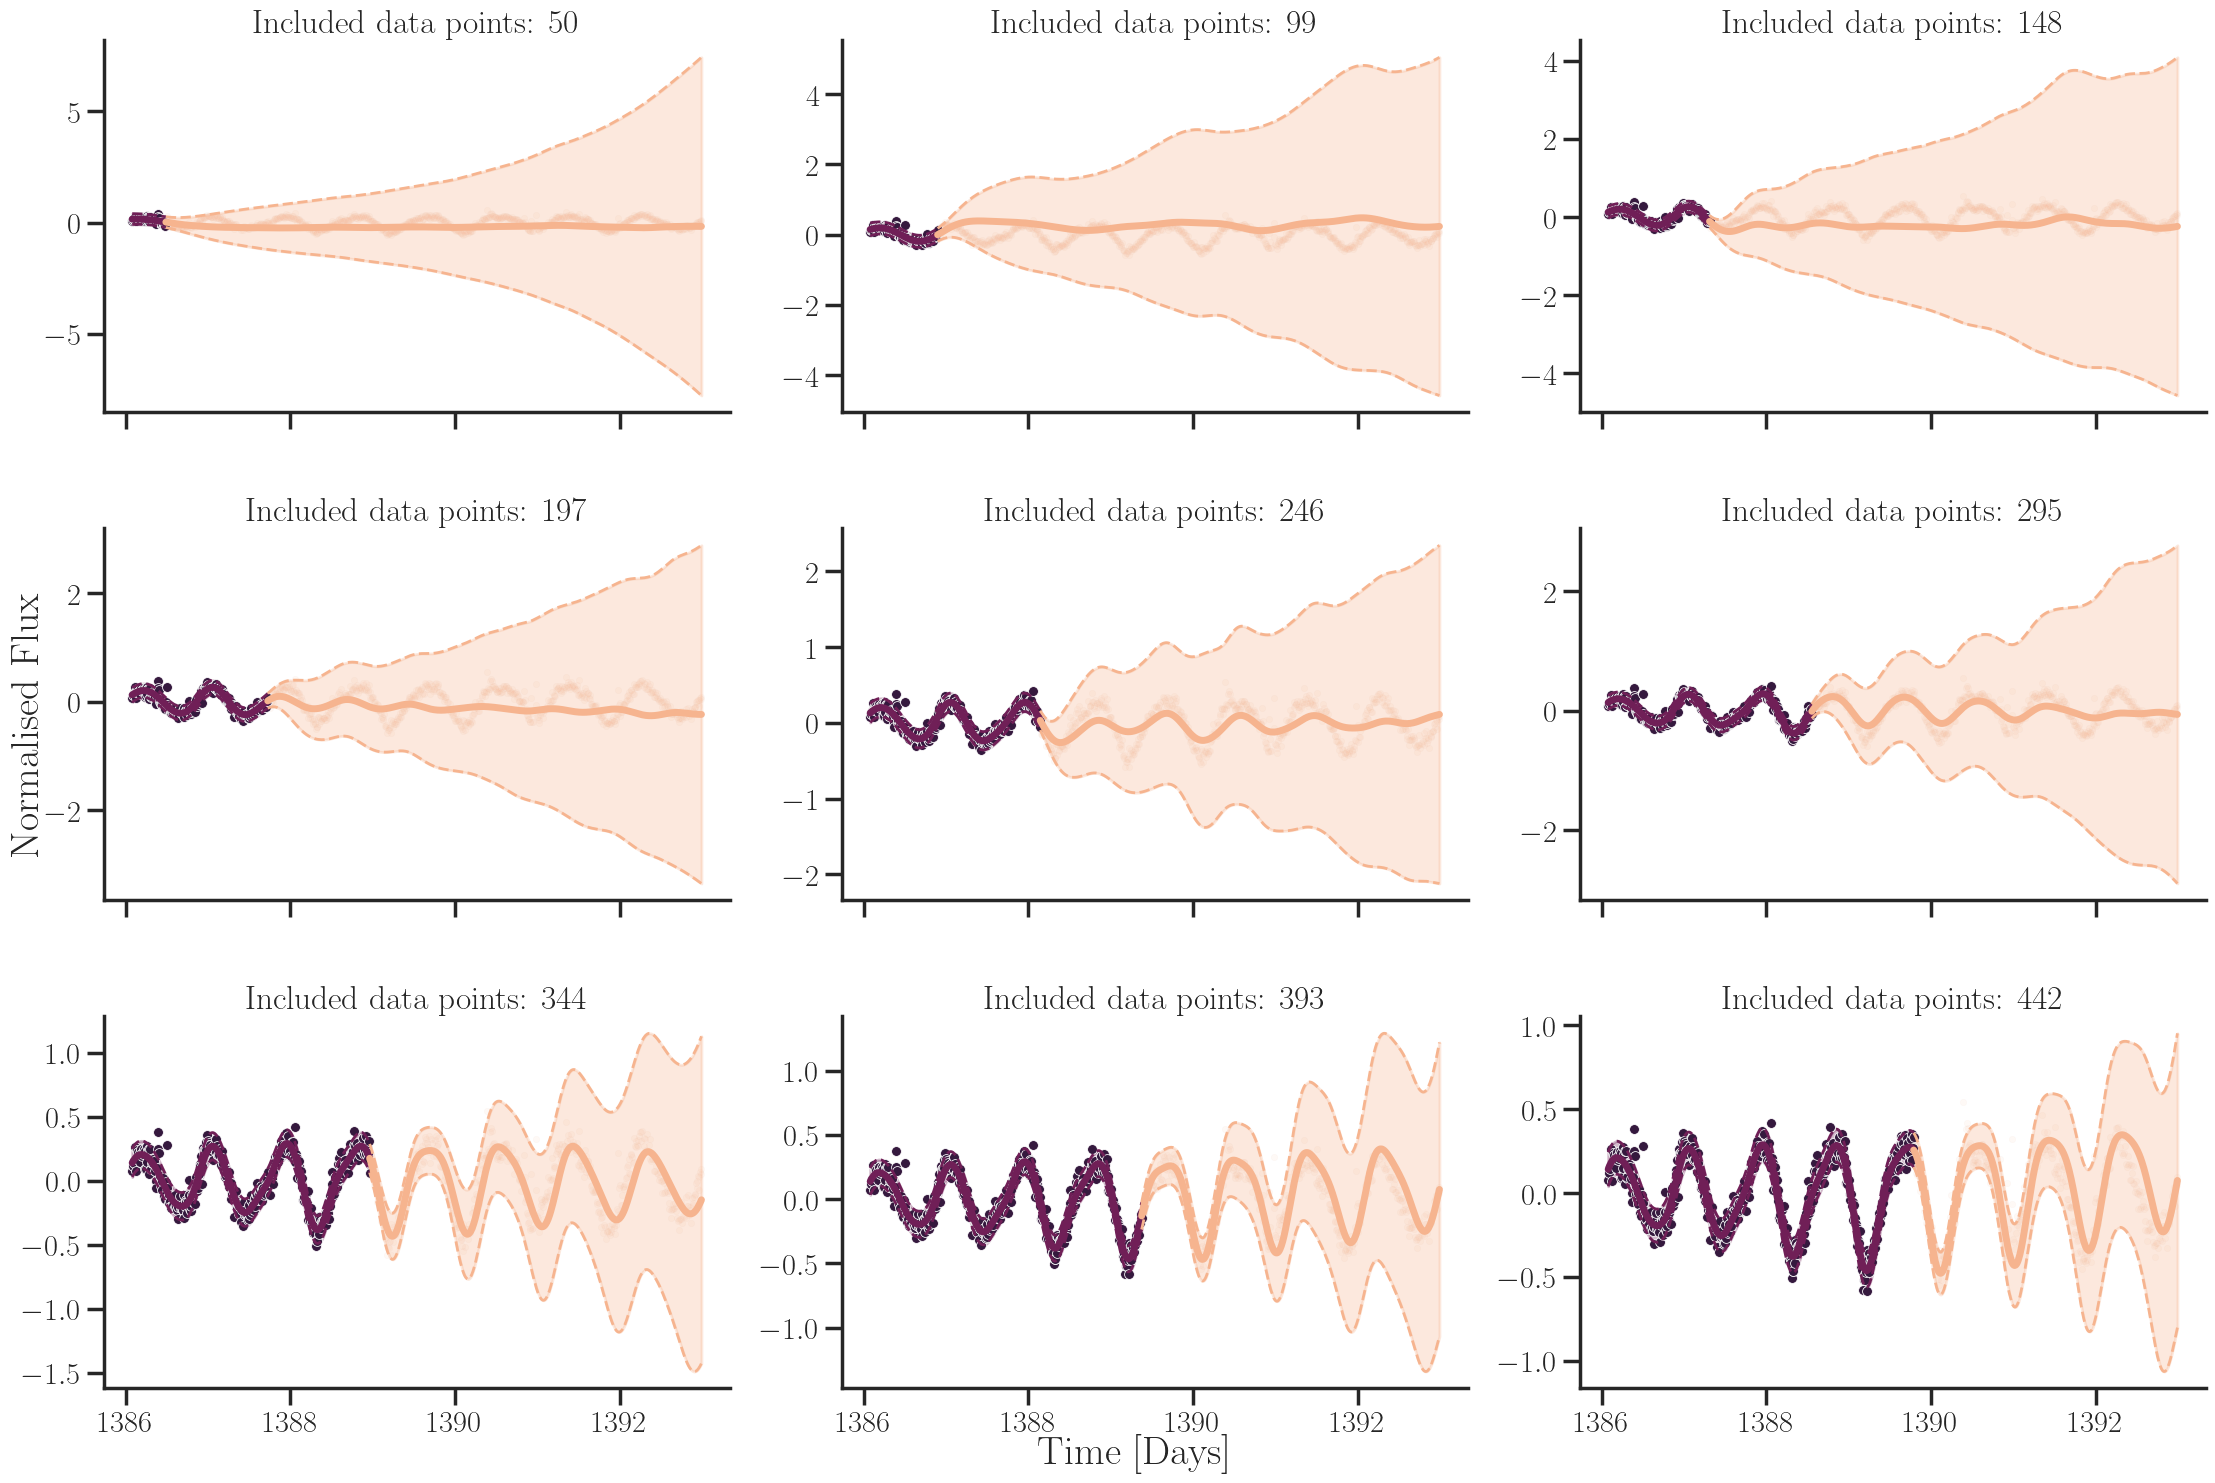

In [53]:
# create plot grid
particle_plot = sns.FacetGrid(
    df,
    col="Datapoints",
    col_wrap=3,
    sharey=False,
    sharex=True,
    height=5,
    aspect=1.5,
)

# plot the predictive mean and standard deviation
for i, ax in enumerate(particle_plot.axes):
    plot_intervals(
        ax,
        xall,
        means[i],
        lower[i],
        upper[i],
        masks[i],
        ["C1", "C5"],
    )
    sns.scatterplot(
        x=xall[: datapoints[i][0]],
        y=gpmodel.y_transform(y)[: datapoints[i][0]],
        color="C0",
        s=50,
        ax=ax,
    )
    sns.scatterplot(
        x=xall[datapoints[i][0] :],
        y=gpmodel.y_transform(y[datapoints[i][0] :]),
        color="C5",
        s=20,
        ax=ax,
        edgecolor=None,
        alpha=0.08,
        zorder=0,
    )


# set titles
for i, ax in enumerate(particle_plot.axes):
    ax.set_title(f"Included data points: {datapoints[i][0]}")


particle_plot.figure.supxlabel("Time [Days]", y=0)
particle_plot.figure.supylabel("Normalised Flux", x=0)
if save_figures:
    particle_plot.savefig(
        figure_directory / "extrapolation_history_plot.pdf", bbox_inches="tight"
    )